# Read and plot DTS data
This notebook shows how to read DTS data from a .csv file and plot it.

In [11]:
# load packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import scipy
from skimage import feature
from tqdm import tqdm
from skimage.filters import meijering, sato, frangi, hessian
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from symfit import parameters, variables, sin, cos, Fit
import pickle
import math
from scipy.interpolate import UnivariateSpline
from PyAstronomy import pyaC
import get_temp_amplitude
# import cv2

# matplotlib.use('TkAgg')
# %matplotlib qt
%matplotlib widget

In [12]:
# Read temperature data
infile = '../data/DTS/temp_cal_valid_cable_rmnoise.csv'
df_temp = pd.read_csv(infile, index_col=0)
df_temp.columns = pd.to_datetime(df_temp.columns)
df_temp.head()

,2023-08-09 17:09:32.415,2023-08-09 17:14:32.521,2023-08-09 17:19:32.622,2023-08-09 17:24:32.751,2023-08-09 17:29:32.871,2023-08-09 17:34:33.023,2023-08-09 17:39:33.151,2023-08-09 17:44:33.281,2023-08-09 17:49:33.393,2023-08-09 17:54:33.510,...,2023-08-29 13:21:53.278,2023-08-29 13:26:53.872,2023-08-29 13:31:54.456,2023-08-29 13:36:55.019,2023-08-29 13:41:55.583,2023-08-29 13:46:56.141,2023-08-29 13:51:56.718,2023-08-29 13:56:57.291,2023-08-29 14:01:57.900,2023-08-29 14:02:08.202
-22.999,21.8724,21.9242,21.7593,22.0574,22.2256,22.5217,22.7067,22.8808,23.2244,23.5173,...,25.5453,25.3991,25.4547,25.4546,25.6803,25.7883,25.9772,25.8514,25.8928,26.1549
-22.745,21.8849,21.9424,21.7415,22.0645,22.2294,22.5077,22.7098,22.8978,23.2494,23.5068,...,25.5339,25.4029,25.4845,25.4733,25.6727,25.8092,25.9818,25.8577,25.9044,26.1569
-22.490,21.8829,21.9581,21.7719,22.0786,22.2661,22.4844,22.7420,22.8877,23.2459,23.5008,...,25.5144,25.4283,25.4984,25.5012,25.6936,25.8112,25.9707,25.8581,25.9104,26.0933
-22.236,21.9095,21.9571,21.7812,22.0970,22.2612,22.4886,22.7592,22.8818,23.2265,23.4932,...,25.5312,25.4563,25.5038,25.5070,25.7078,25.7885,25.9619,25.8641,25.9341,26.1819
-21.982,21.9441,21.9227,21.7831,22.0871,22.2620,22.5016,22.7392,22.8826,23.2373,23.5235,...,25.5722,25.4460,25.5155,25.5173,25.7258,25.8020,25.9593,25.8840,25.9210,26.2319


In [13]:
# Put temperature data, optical distances and sampling times into numpy arrays
temp_arr = df_temp.to_numpy().T # we want to have the time to be in the 0-axis to be consistent with DAS data
times = pd.to_datetime(df_temp.columns)
dists = df_temp.index.to_numpy()

In [14]:
# plot selected DTS data over time
# enter water at: 560m, exit water at 7565m
start_dist = 2820 # east ridge at 2820m optical distance
end_dist = 3150 # seafloor from ~3150m optical distance onward

start_time = times[0] #datetime.datetime(2023,8,9)
end_time = times[-1] #datetime.datetime(2023,8,30)

t_idx_start = np.argmin(np.abs(times-start_time))
t_idx_end = np.argmin(np.abs(times-end_time))
d_idx_start = np.argmin(np.abs(dists-start_dist))
d_idx_end = np.argmin(np.abs(dists-end_dist))

plot_arr = temp_arr[t_idx_start:t_idx_end, d_idx_start:d_idx_end]
plot_times = times[t_idx_start:t_idx_end]
plot_dists = dists[d_idx_start:d_idx_end]


In [15]:
plot_times_zoomed_int = scipy.ndimage.zoom(plot_times.astype('int64'), 4)
plot_times_zoomed = plot_times_zoomed_int.astype('datetime64')

In [16]:
# filter = scipy.signal.butter(1, 0.0111, 'hp', fs=5, output='sos', analog=False) # 5 represents 5 second sampling rate
# Band pass filter 
filtered_arr = scipy.ndimage.gaussian_filter(plot_arr, 10, axes=1)
startt = plot_times[0]# datetime.datetime(2023, 8, 15, 8)
endt = plot_times[-1] # datetime.datetime(2023, 8, 16, 16)
startind_t = np.absolute(plot_times - startt).argmin()
endind_t = np.absolute(plot_times - endt).argmin()

startind_d = 0 #np.absolute(plot_dists - 2940).argmin()
endind_d = len(plot_dists) #np.absolute(plot_dists - 3000).argmin()

filtered_arr = scipy.ndimage.gaussian_filter(filtered_arr[startind_t:endind_t, startind_d:endind_d], 1.2)
plot_times_zoomed = plot_times[startind_t:endind_t]
plot_dists_zoomed = plot_dists[startind_d:endind_d]

# Detecting the amplitude of the waves

## Making my own contours

In [17]:
contour_values = [2] # 0.7, 1, 1.3, 1.6, 2, 
contour_values_legend = []
for i in range(len(contour_values)): contour_values_legend.append(str(contour_values[i]) + "ºC")

contour_points = {}
# np.empty((len(contour_values), len(filtered_arr[:, 1])))

for cv in contour_values:
    avg_zero_crossings = 0
    contour_points[cv] = {}
    contour_points[cv]['x'] = []
    contour_points[cv]['t'] = []
    for i in range(len(filtered_arr[:, 0])):
        xc = pyaC.zerocross1d(plot_dists_zoomed, filtered_arr[i, :] - cv)
        contour_points[cv]['x'].extend(xc.flatten().tolist())
        contour_points[cv]['t'].extend(np.full(len(xc), plot_times_zoomed[i]).tolist())
        avg_zero_crossings = avg_zero_crossings + len(xc)

    print('Temp contour =', cv, 'avg of', round(avg_zero_crossings/len(filtered_arr[:, 0]), 3), 'zero crossings')

# np.interp(xc, plot_dists_zoomed, filtered_arr[i, :])

Temp contour = 2 avg of 1.315 zero crossings


## Plotting

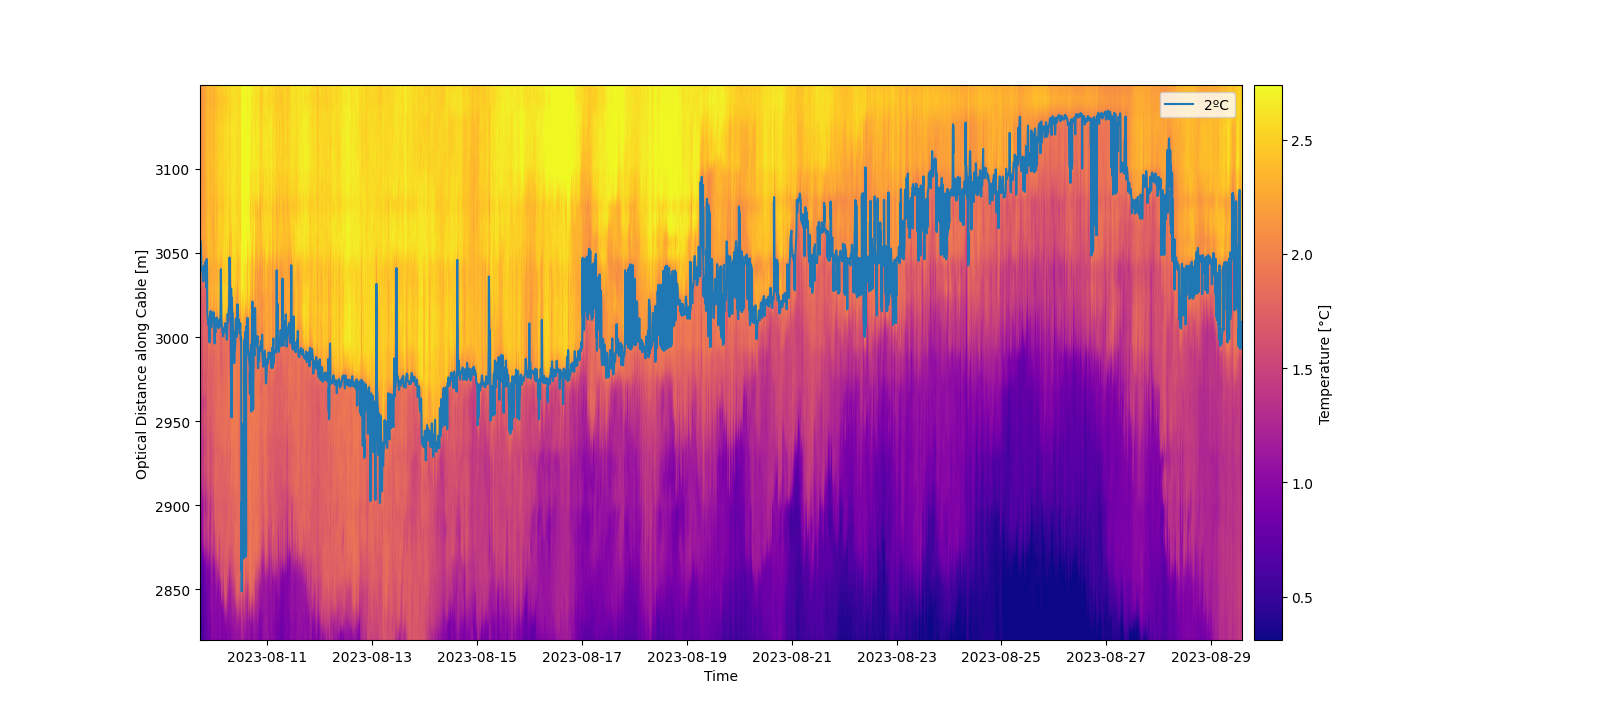

In [18]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
im1 = ax.imshow(filtered_arr.T, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='plasma',
            vmin=np.percentile(filtered_arr[~np.isnan(filtered_arr)],1),
            vmax=np.percentile(filtered_arr[~np.isnan(filtered_arr)],99),
            )
ax.set_ylabel('Optical Distance along Cable [m]')
ax.set_xlabel('Time')
# for i in range(len(contour_points[contour_values[i]]['t'])):
#     for j in range(len(contour_points[contour_values[i]]['x'])):
#         nexttinds = 

for i in range(len(contour_values)): plt.plot(contour_points[contour_values[i]]['t'], contour_points[contour_values[i]]['x'], '-')
# plt.contour(plot_times_zoomed, plot_dists_zoomed, filtered_arr.T, contour_values)
# ax.axvline(x=plot_times[sliceind])
plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Temperature [°C]')
plt.show()

In [19]:
sos = scipy.signal.butter(1, 0.025, 'hp', fs=0.2, output='sos')
contours_filtered = {}
for i in range(len(contour_values)):
    contours_filtered[i] = scipy.signal.sosfilt(sos, contour_points[i] - np.median(contour_points[i]))

peak_locs = {}
dT = {}
peaks_arr = np.zeros(np.shape(filtered_arr))
p = 2
# Find peaks
peak_dists_ind = {}
for i in range(len(contour_values)):
    peaks_m = scipy.signal.find_peaks(-(contours_filtered[i]), prominence=p, distance=3)[0]
    peaks_p = scipy.signal.find_peaks(contours_filtered[i], prominence=p, distance=3)[0]
    peak_dists_ind[i] = np.concatenate((peaks_p, peaks_m))

# peaks_arr[i, peak_dists_ind] = amplitudes

KeyError: 0

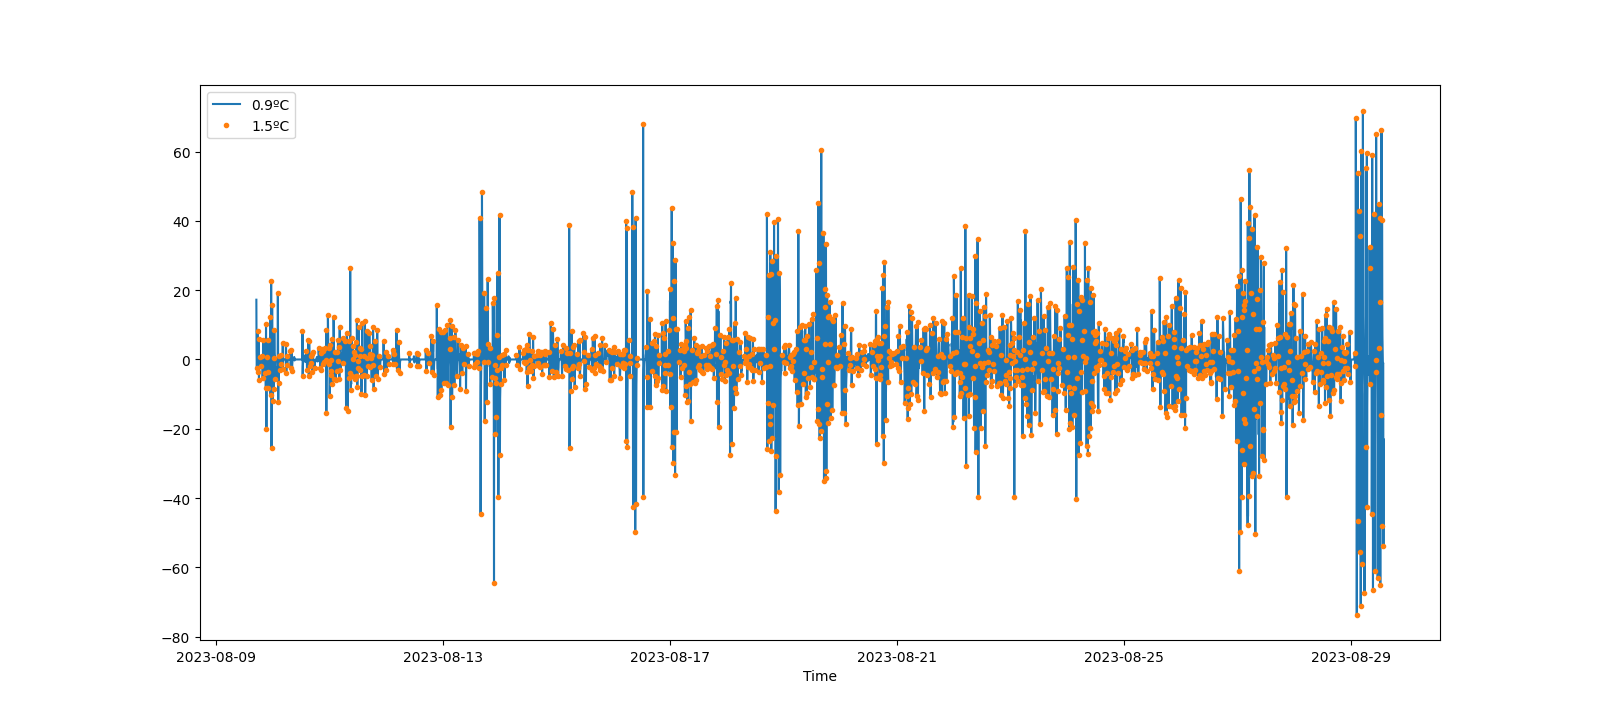

In [ ]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))

ax.set_xlabel('Time')
# plt.plot(plot_times_zoomed, contour_points[0] - np.mean(contour_points[0]))
# for i in range(len(contour_values)):
s1 = 150
s2 = 220
plt.plot(plot_times_zoomed, contours_filtered[0])
plt.plot(plot_times_zoomed[peak_dists_ind[0]], contours_filtered[0][peak_dists_ind[0]], '.')

plt.legend(contour_values_legend)
plt.show()

## Plot the amplitude of spikes

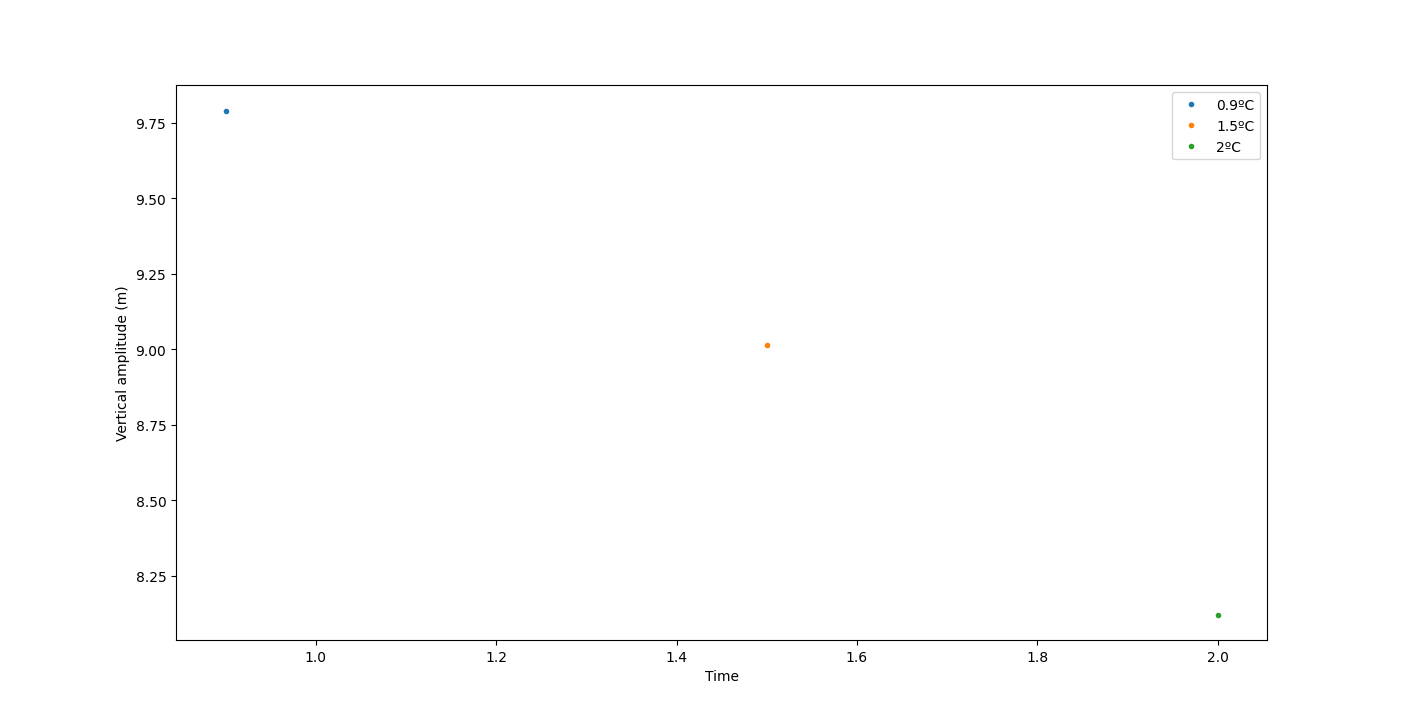

In [ ]:
fig, ax = plt.subplots(figsize=(2.2*6.4,1.5*4.8))

for i in range(len(contour_values)):
    # plt.plot(plot_times_zoomed[sorted(peak_dists_ind[i])], np.abs(contours_filtered[i][sorted(peak_dists_ind[i])]), '-')
    plt.plot(contour_values[i], np.mean(np.abs(contours_filtered[i][sorted(peak_dists_ind[i])])), '.')

ax.set_xlabel("Time")
ax.set_ylabel("Vertical amplitude (m)")
plt.legend(contour_values_legend)
plt.show()


## Plot the rolling $\sigma$ of the countours

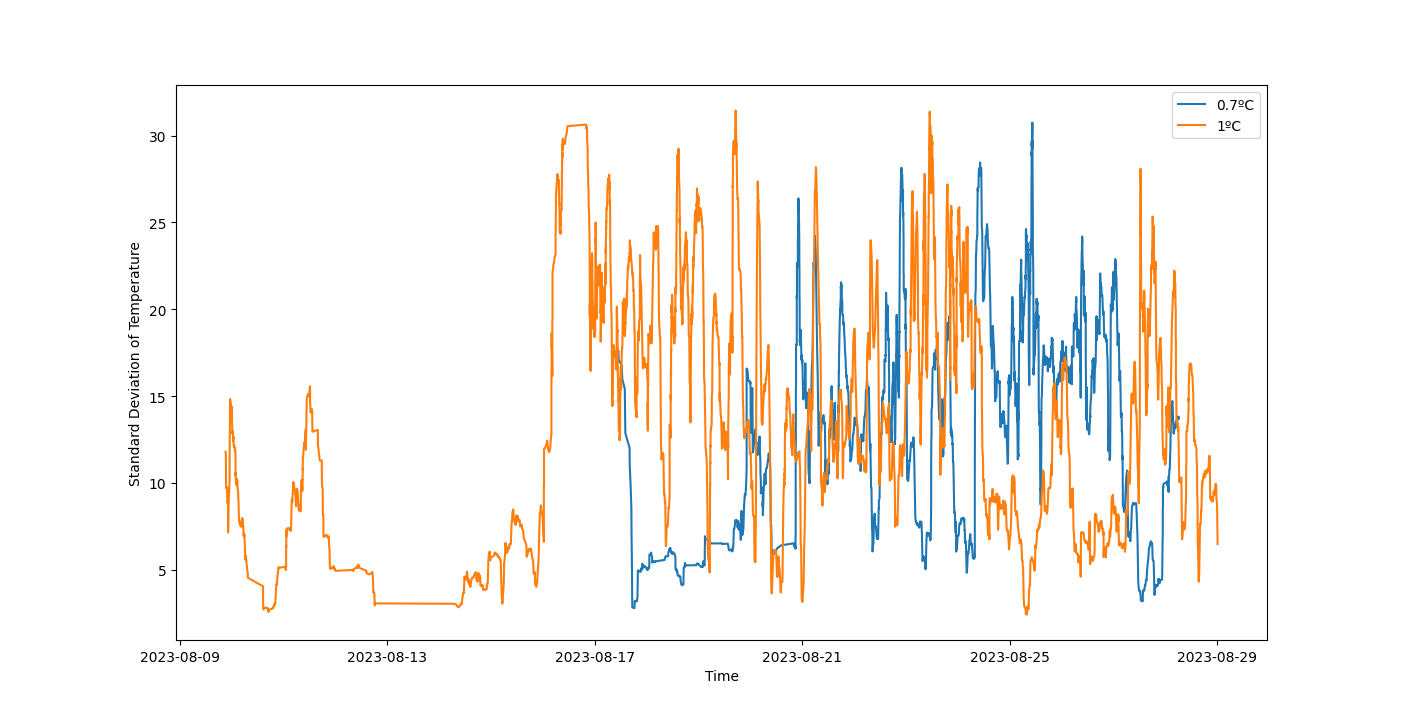

In [ ]:
fig, ax = plt.subplots(figsize=(2.2*6.4,1.5*4.8))

contour_range = [0, 2]
# plt.plot([np.std(contours_filtered[6][0:s1]), np.std(contours_filtered[6][s1:s2]), np.std(contours_filtered[6][s2:])], '.')
for i in contour_values[contour_range[0]:contour_range[1]]: 
    plt.plot(contour_points[i]['t'], pd.DataFrame(contour_points[i]['x']).rolling(50).std())
# plt.plot(plot_times_zoomed, pd.DataFrame(contours_filtered[1]).rolling(50).std())
# plt.plot(contour_points[contour_values[0]]['t'], pd.DataFrame(contour_points[contour_values[0]]['x']).rolling(50).std())

ax.set_xlabel("Time")
ax.set_ylabel("Standard Deviation of Temperature")
plt.legend(contour_values_legend[contour_range[0]:contour_range[1]])
plt.show()


# Computing cross correlations

Finished


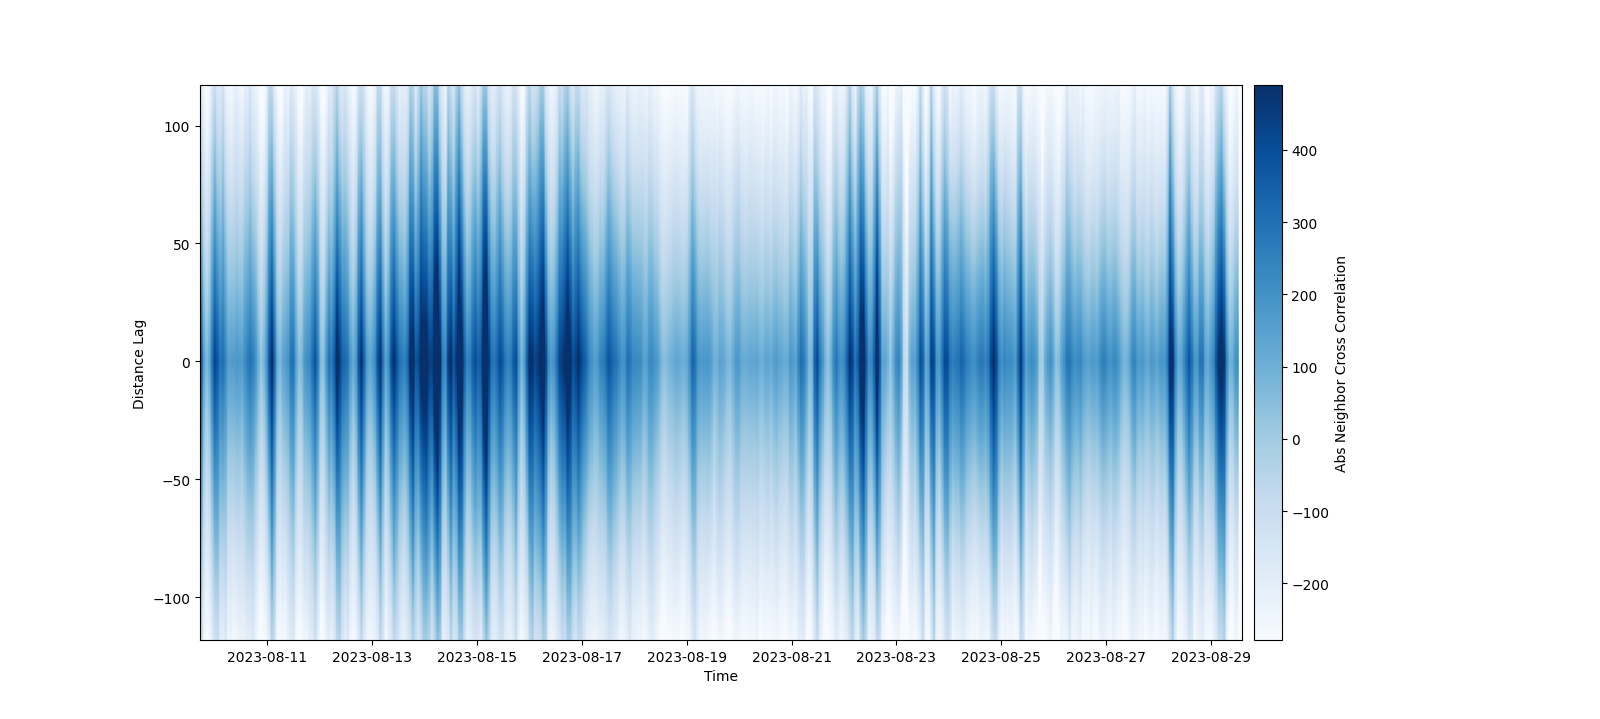

In [ ]:
corr_matrix = np.empty(np.shape(filtered_arr))
lags = scipy.signal.correlation_lags(len(filtered_arr[0, :]), len(filtered_arr[1, :]), mode='same')
for i in range(len(filtered_arr[:, 0])):                       
    try:
        corr_matrix[i, :] = corr_matrix[i, :] - np.mean(corr_matrix[i, :])
        corr_matrix[i, :] = corr_matrix[i + 1, :] - np.mean(corr_matrix[i + 1, :])
        corr_matrix[i, :] = np.correlate(filtered_arr[i, :], filtered_arr[i + 1, :], mode='same')
    except: print('Finished')
corr_matrix = corr_matrix - np.median(corr_matrix)

fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
im1 = ax.imshow(corr_matrix.T, origin='lower',
           aspect='auto',
            extent=[plot_times[0], plot_times[-1],
                   lags[0], lags[-1]],
            cmap='Blues',
            vmin=np.percentile(corr_matrix[~np.isnan(corr_matrix)],1),
            vmax=np.percentile(corr_matrix[~np.isnan(corr_matrix)],99),
            )

ax.set_ylabel('Distance Lag')
ax.set_xlabel('Time')

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Abs Neighbor Cross Correlation')
plt.show()

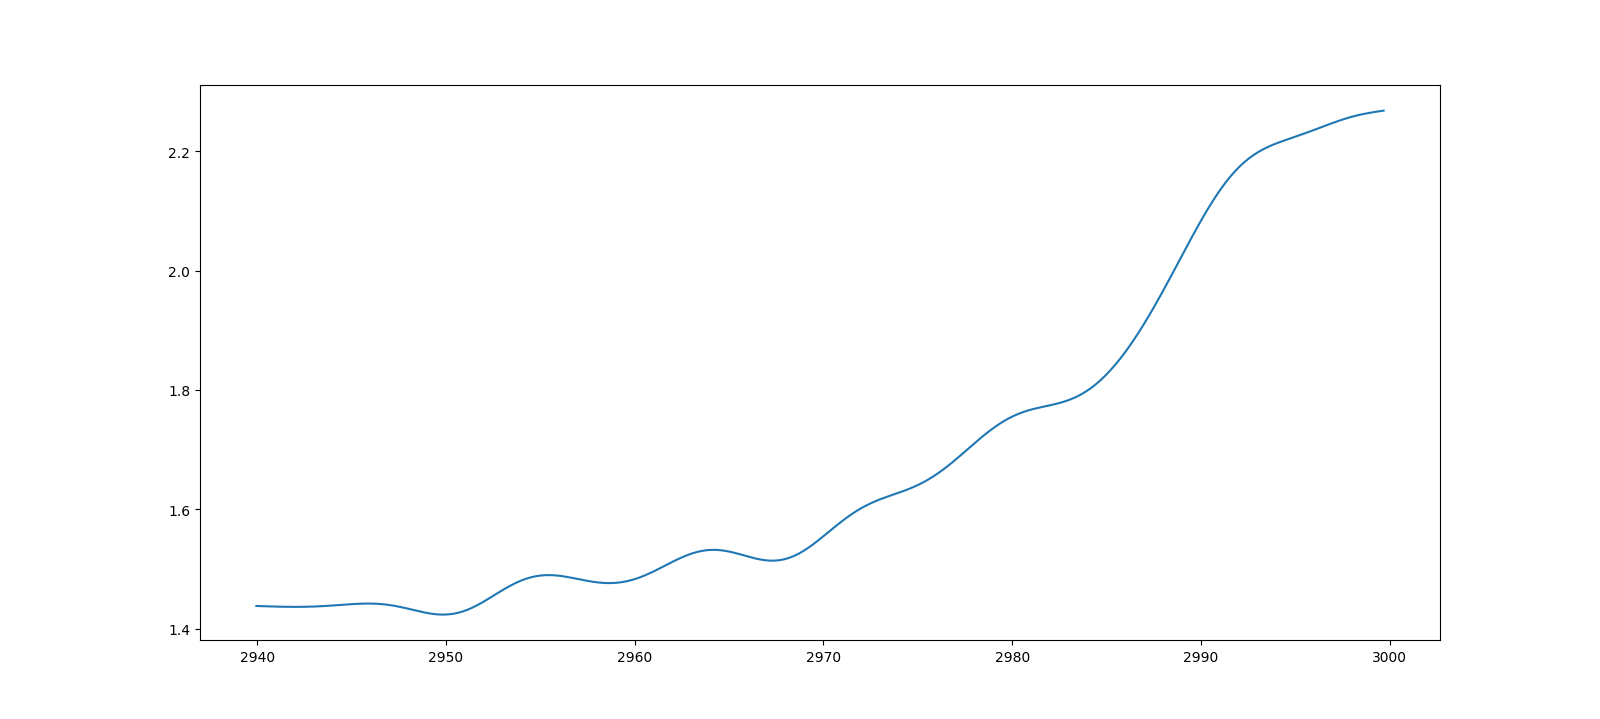

In [ ]:
# mean_dist_lag = np.mean(corr_matrix, axis=1)

fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
plt.plot(plot_dists_zoomed, filtered_arr[3, :])
plt.show()

# Calculate $T/\frac{dT}{dz}$

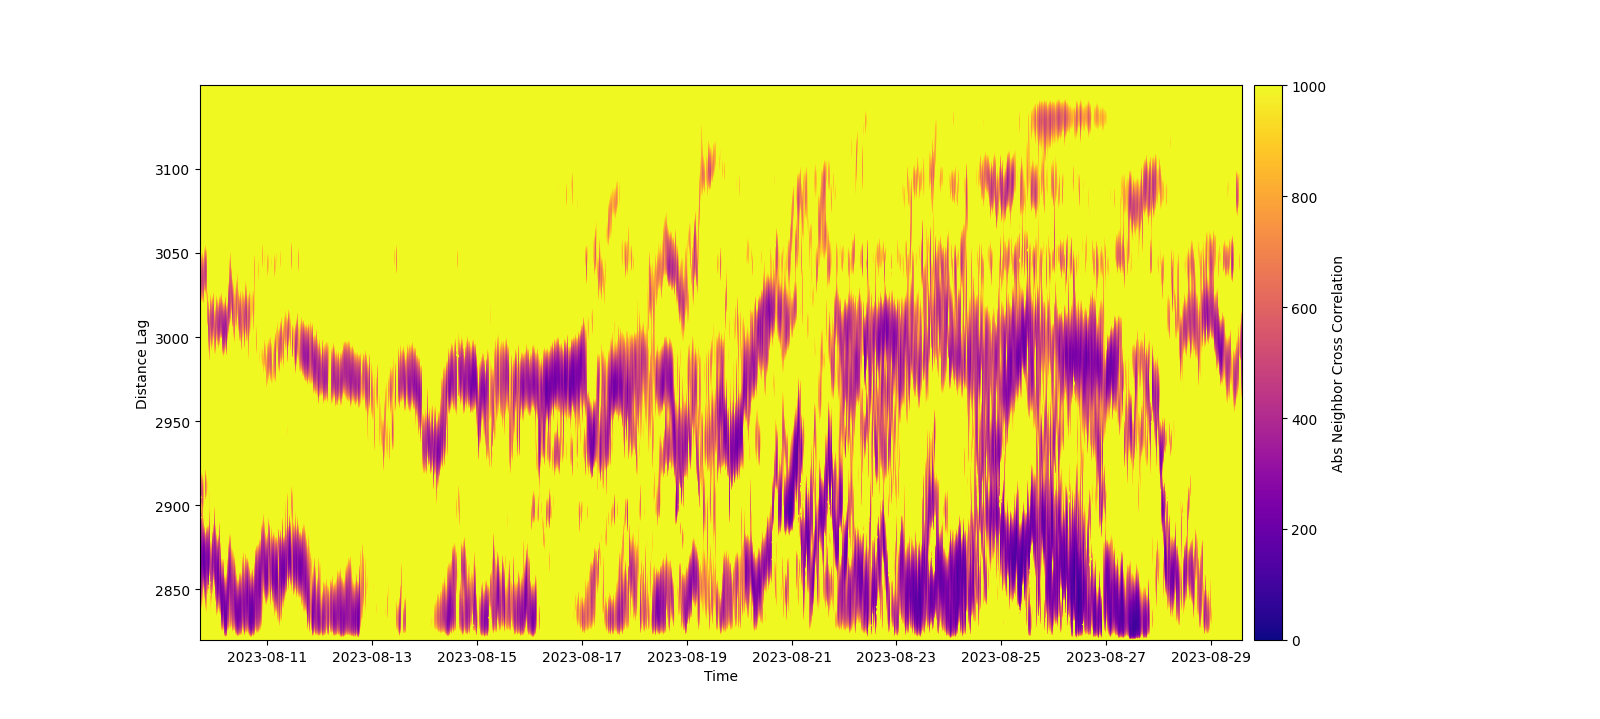

In [27]:
dtdz = np.abs(filtered_arr/scipy.ndimage.gaussian_filter(filtered_arr, 40, order=1, axes=1))
# dtdz = np.abs(scipy.ndimage.gaussian_filter(filtered_arr, 40, order=1, axes=1))

fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
im1 = ax.imshow(dtdz.T, origin='lower',
           aspect='auto',
            extent=[plot_times[0], plot_times[-1],
                   plot_dists[0], plot_dists[-1]],
            cmap='plasma',
            vmin=0,
            vmax=1000,
            )

ax.set_ylabel('Distance Lag')
ax.set_xlabel('Time')

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Abs Neighbor Cross Correlation')
plt.show()